https://www.mktr.ai/applications-and-methods-in-data-science-customer-segmentation/

In [2]:
import os

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline  
import pandas as pd
from sklearn.cluster import KMeans
import datetime
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./Sales_Data/data.csv")
#df2 = pd.read_excel(url)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/10 8:26,3.39,17850.0,United Kingdom


In [3]:
# df.to_csv ("./Sales_Data/data.csv", index = False, header=True)


## Data Cleanup

Below, we are going to remove data that isn’t helpful, is missing, or may cause issues later.

In [4]:
# Drop cancelled orders
df1 = df.loc[df['Quantity'] > 0]
print(df.info())

df2 = df[df['Quantity'] > 0]
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 531285 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      531285 non-null object
StockCode      531285 non-null object
Description    530693 non-null object
Quantity       531285 non-null int64
InvoiceDate    531285 non-null object
UnitPrice      531285 non-null float64
CustomerID     397924 non-null float64
Country        531285 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 36.5+ MB
None


In [5]:
print(all(df1 == df2))

print(df1.equals(df2))

True
True


In [6]:
# Drop records without CustomerID
df1 = df1[pd.notnull(df['CustomerID'])]

# Drop incomplete month
df1 = df1.loc[df['InvoiceDate'] < '2011-12-01']

# Calculate total sales from the Quantity and UnitPrice
df1['Sales'] = df1['Quantity'] * df1['UnitPrice']

In [50]:
df1.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/10 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,1/12/10 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/10 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/10 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/10 8:26,3.39,17850.0,United Kingdom,20.34


Now let’s transform the data so that each record represents a single customer’s purchase history.

In [51]:
# use groupby to aggregate sales by CustomerID
customer_df = df1.groupby('CustomerID').agg({'Sales': sum, 
                                            'InvoiceNo': lambda x: x.nunique()})

# Select the columns we want to use
customer_df.columns = ['TotalSales', 'OrderCount'] 

# create a new column 'AvgOrderValu'
customer_df['AvgOrderValue'] = customer_df['TotalSales'] / customer_df['OrderCount']

customer_df.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600
12347.0,584.91,1,584.910
12348.0,892.80,1,892.800
12350.0,334.40,1,334.400
12352.0,1767.73,5,353.546


## Normalize the data

Clustering algorithms like K-means are sensitive to the scales of the data used, so we’ll want to normalize the data.

Below is a screenshot from part of a StackExchange answer discussing why standardization or normalization is 
necessary for data used in K-means clustering. The screenshot is linked to the StackExchange question, 
so you can click on it and read the entirety of the discussion if you’d like more information.

In [52]:
rank_df = customer_df.rank(method='first')
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.727732,-1.731187,1.731187
12347.0,0.252249,-1.730035,1.218627
12348.0,0.665753,-1.728883,1.488153
12350.0,-0.435388,-1.727732,0.334028
12352.0,1.241663,1.269307,0.463032
12353.0,-1.592968,-1.726580,-1.539985
12356.0,1.393703,-0.005759,1.604487
12358.0,0.035706,-1.725428,1.014754
12359.0,1.535377,-0.004607,1.670140


## Select the optimal number of clusters

Alright, we’re ready to run cluster analysis. But first, we need to figure out how many clusters we want to use. 
There are several approaches to selecting the number of clusters to use, but I’m going to cover two in this 
article: (1) silhouette coefficient, and (2) the elbow method.


# The Elbow Method with the Sum of Squared Errors (SSE)

We will check out the kink, which will be the optimal.

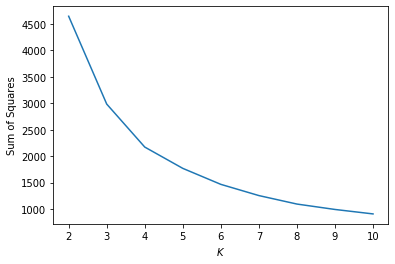

"\nIt is a rather smooth curve, so we will use Silhouette. \nThis graph suggests number 4, let's see if it is.\n"

In [68]:
from sklearn import cluster
import numpy as np
import matplotlib.pyplot as plt 


sse = []
krange = list(range(2,11))

X = normalized_df[['TotalSales','OrderCount','AvgOrderValue']].values
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=3)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    sse.append(np.sum((X - centers[cluster_assignments]) ** 2))

plt.plot(krange, sse)
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")
plt.show()

"""
It is a rather smooth curve, so we will use Silhouette. 
This graph suggests number 4, let's see if it is.
"""

# Silhouette

For a quick rundown on silhouette, check out the screenshot from Wikipedia below. Once again, the image is linked 
to the Wikipedia page, so if you want to know more about the topics, click on the image.

In [70]:
# Use silhouette coefficient to determine the best number of clusters
from sklearn.metrics import silhouette_score

cluster_range = list(range(2,10))

for n in cluster_range:
    kmeans = KMeans(n_clusters=n).fit(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])
    
    silhouette_avg = silhouette_score(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']], 
        kmeans.labels_)
    
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

"""
So 3 is the optimal.

"""

Silhouette Score for 9 Clusters: 0.4179
Silhouette Score for 9 Clusters: 0.4230
Silhouette Score for 9 Clusters: 0.4165
Silhouette Score for 9 Clusters: 0.3886
Silhouette Score for 9 Clusters: 0.3746
Silhouette Score for 9 Clusters: 0.3834
Silhouette Score for 9 Clusters: 0.3691
Silhouette Score for 9 Clusters: 0.3543


'\nSo 3 is the optimal .\n\n'

# Interpreting Customer Segments

In [74]:
kmeans = KMeans(n_clusters=3).fit(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])

three_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
three_cluster_df['Cluster'] = kmeans.labels_

three_cluster_df.head(10)


,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.727732,-1.731187,1.731187,1
12347.0,0.252249,-1.730035,1.218627,1
12348.0,0.665753,-1.728883,1.488153,1
12350.0,-0.435388,-1.727732,0.334028,1
12352.0,1.241663,1.269307,0.463032,0
12353.0,-1.592968,-1.726580,-1.539985,2
12356.0,1.393703,-0.005759,1.604487,0
12358.0,0.035706,-1.725428,1.014754,1
12359.0,1.535377,-0.004607,1.670140,0


In [77]:
cluster1_metrics = kmeans.cluster_centers_[0]
cluster2_metrics = kmeans.cluster_centers_[1]
cluster3_metrics = kmeans.cluster_centers_[2]

data = [cluster1_metrics, cluster2_metrics, cluster3_metrics]
cluster_center_df = pd.DataFrame(data)

cluster_center_df.columns = three_cluster_df.columns[0:3]
cluster_center_df

,TotalSales,OrderCount,AvgOrderValue
0,0.958740,0.968947,0.427677
1,0.033273,-0.949696,0.841736
2,-1.033641,-0.409417,-0.995263


In [79]:
print(cluster1_metrics)

[0.95873953 0.96894712 0.42767653]


For this next piece, we are going to visualize the clusters by putting the different columns on the x and y-axes. 
Let’s see what we get.

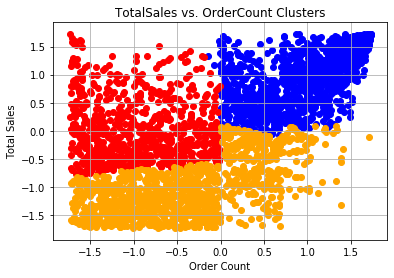

In [91]:
plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['OrderCount'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['TotalSales'],
    c='blue')

plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['OrderCount'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['TotalSales'],
    c='red')

plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 2]['OrderCount'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 2]['TotalSales'],
    c='orange')

plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 3]['OrderCount'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 3]['TotalSales'],
    c='green')

plt.title('TotalSales vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.grid()
plt.show()

In [92]:
"""
The customers in yellow have low total sales AND low order count, meaning they are all-around low-value customers. 
On the other hand, the customers in blue have high total sales AND high order counts, indicating they are 
the highest value customers.
"""

'\nThe customers in green have low total sales AND low order count, meaning they are all-around low-value customers. \nOn the other hand, the customers in orange have high total sales AND high order counts, indicating they are \nthe highest value customers.\n'

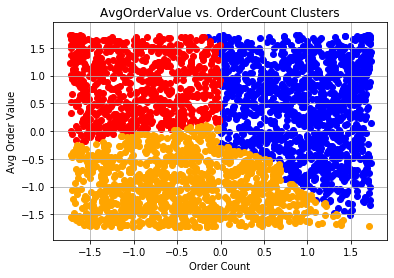

In [88]:
plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['OrderCount'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='blue')

plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['OrderCount'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red')

plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 2]['OrderCount'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='orange')

plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 3]['OrderCount'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='green')

plt.title('AvgOrderValue vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()

In [89]:
"""
## In this plot, we’re looking at the average order value vs the order count. Once again, the customers in yellow 
are the lowest value customers and the customers in *blue are the highest value customers.

You could look at this in another way. ** You could look at the customers in the red cluster and attempt to find ways 
to increase their order count with email reminders or SMS push notifications targeted based on some other 
identifying factors. ** Maybe you could email them a discount if they return within 30 days. Better yet, 
you can offer a delayed coupon (to be used in a specific time period) upon checkout.

Likewise, with customers in the blue segment, you might want to try some ** cross-selling and up-selling **
techniques at the cart. Maybe a quick pop-up with an offer, based on market basket analysis 
(see the market basket analysis section below).
"""


'\n## In this plot, we’re looking at the average order value vs the order count. Once again, the customers in green \nare the lowest value customers and the customers in orange are the highest value customers.\n\nYou could look at this in another way. You could look at the customers in the red cluster and attempt to find ways \nto increase their order count with email reminders or SMS push notifications targeted based on some other \nidentifying factors. Maybe you could email them a discount if they return within 30 days. Better yet, \nyou can offer a delayed coupon (to be used in a specific time period) upon checkout.\n\nLikewise, with customers in the blue segment, you might want to try some cross-selling and up-selling \ntechniques at the cart. Maybe a quick pop-up with an offer, based on market basket analysis \n(see the market basket analysis section below).\n'

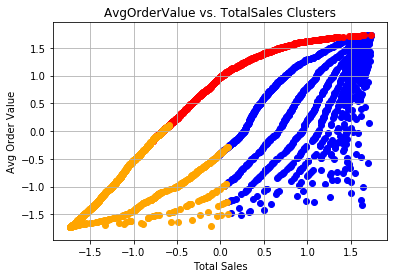

In [90]:
plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['TotalSales'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='blue')

plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['TotalSales'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red')

plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 2]['TotalSales'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='orange')

plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 3]['TotalSales'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='green')

plt.title('AvgOrderValue vs. TotalSales Clusters')
plt.xlabel('Total Sales')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()

In [4]:
"""
In this plot, we have the average order value versus total sales clusters. This plot further substantiates 
the previous 2 plots in identifying the blue cluster as the highest value customers, yellow as the lowest 
value customers, and the blue and red as high opportunity customers.

From a growth perspective, I’d focus my attention on the blue and red clusters. I’d attempt to better 
understand each cluster and their granular behaviors on-site in order to identify which cluster to focus 
on first and inform the first few rounds of experiments.
"""

# Find the best-selling item by segment

'\nIn this plot, we have the average order value versus total sales clusters. This plot further substantiates \nthe previous 2 plots in identifying the blue cluster as the highest value customers, yellow as the lowest \nvalue customers, and the blue and red as high opportunity customers.\n\nFrom a growth perspective, I’d focus my attention on the blue and red clusters. I’d attempt to better \nunderstand each cluster and their granular behaviors on-site in order to identify which cluster to focus \non first and inform the first few rounds of experiments.\n'

In [5]:
high_value_cluster = three_cluster_df.loc[three_cluster_df['Cluster'] == 2]

pd.DataFrame(df.loc[df['CustomerID'].isin(high_value_cluster.index)].groupby(
    'Description').count()['StockCode'].sort_values(ascending=False).head())



NameError: name 'four_cluster_df' is not defined

In [ ]:
"""
According to the segmentation, suggest to them the best suitable products to them

Based on this information, we now know that the Jumbo Bag Red Retrospot is the best-selling item 
for our highest-value cluster. With that information in hand, we can make recommendations of Other Items 
You Might Like to customers within this segment. These actions can be taken to another level of specificity 
with Association Rule Mining and Market Basket Analysis which I’ll cover below.
"""
